In [1]:
# Détecteur de Phishing - Version Inférence Uniquement
# Ce script utilise un modèle déjà entraîné pour faire des prédictions

import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Bibliothèques pour DistilBERT
from transformers import (
    DistilBertTokenizer,
    DistilBertForSequenceClassification,
    Trainer
)

# Bibliothèques pour l'évaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from torch.utils.data import Dataset

print("Bibliothèques importées avec succès")

/home/dertyxx/Documents/phishing-email-detector/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Bibliothèques importées avec succès


In [2]:
# =============================================================================
# 1. CHARGEMENT DU MODÈLE PRÉ-ENTRAÎNÉ
# =============================================================================

def load_pretrained_model(model_path="./phishing-detector-model"):
    """
    Charge un modèle DistilBERT déjà entraîné depuis le disque
    
    Args:
        model_path (str): Chemin vers le dossier contenant le modèle
        
    Returns:
        tuple: (tokenizer, model)
    """
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Le dossier du modèle '{model_path}' n'existe pas.")
    
    print(f"Chargement du modèle depuis : {model_path}")
    
    # Charger le tokenizer
    tokenizer = DistilBertTokenizer.from_pretrained(model_path)
    print("Tokenizer chargé")
    
    # Charger le modèle
    model = DistilBertForSequenceClassification.from_pretrained(model_path)
    print("Modèle chargé")
    
    # Mettre le modèle en mode évaluation
    model.eval()
    
    return tokenizer, model

# Charger le modèle pré-entraîné
try:
    tokenizer, model = load_pretrained_model()
    print("Modèle chargé avec succès !")
except FileNotFoundError as e:
    print(f"Erreur : {e}")
    print("Assurez-vous d'avoir d'abord entraîné le modèle avec le script d'entraînement.")
    exit(1)

Chargement du modèle depuis : ./phishing-detector-model
Tokenizer chargé
Modèle chargé
Modèle chargé avec succès !


In [3]:
# =============================================================================
# 2. CLASSE DATASET POUR L'INFÉRENCE
# =============================================================================

class EmailDataset(Dataset):
    """
    Dataset personnalisé pour l'inférence sur les emails
    """
    
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx] if self.labels else 0  # Label par défaut si non fourni
        
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [4]:
# =============================================================================
# 3. FONCTIONS DE PRÉDICTION
# =============================================================================

def predict_single_email(text, model, tokenizer):
    """
    Prédit si un seul email est du phishing ou non
    
    Args:
        text (str): Texte de l'email à analyser
        model: Modèle DistilBERT entraîné
        tokenizer: Tokenizer correspondant
        
    Returns:
        tuple: (prédiction_str, classe_prédite, probabilités)
    """
    # Déterminer le device
    device = next(model.parameters()).device
    
    # Encoder le texte
    inputs = tokenizer(
        text,
        return_tensors='pt',
        truncation=True,
        padding=True,
        max_length=512
    )
    
    # Déplacer sur le bon device
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    # Faire la prédiction
    with torch.no_grad():
        outputs = model(**inputs)
        probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)
        predicted_class = torch.argmax(probabilities, dim=-1).item()
        confidence = probabilities[0][predicted_class].item()
    
    # Convertir en texte lisible
    prediction_text = "Phishing Email" if predicted_class == 1 else "Safe Email"
    
    return prediction_text, predicted_class, probabilities[0].cpu().numpy()

def predict_batch_emails(texts, model, tokenizer, labels=None):
    """
    Prédit sur un lot d'emails
    
    Args:
        texts (list): Liste des textes d'emails
        model: Modèle entraîné
        tokenizer: Tokenizer
        labels (list, optional): Vraies étiquettes si disponibles
        
    Returns:
        tuple: (prédictions, probabilités) ou (prédictions, probabilités, métriques)
    """
    if labels is None:
        labels = [0] * len(texts)  # Labels factices
    
    # Créer le dataset
    dataset = EmailDataset(texts, labels, tokenizer)
    
    # Créer un trainer pour l'inférence
    trainer = Trainer(model=model)
    
    # Faire les prédictions
    print("Prédiction en cours...")
    predictions = trainer.predict(dataset)
    y_pred = np.argmax(predictions.predictions, axis=1)
    probabilities = torch.nn.functional.softmax(torch.tensor(predictions.predictions), dim=-1)
    
    # Si nous avons les vraies étiquettes, calculer les métriques
    metrics = None
    if any(label != 0 for label in labels):  # Vérifier si ce ne sont pas que des labels factices
        accuracy = accuracy_score(labels, y_pred)
        metrics = {
            'accuracy': accuracy,
            'predictions': y_pred,
            'true_labels': labels
        }
    
    return y_pred, probabilities.numpy(), metrics

In [ ]:
# =============================================================================
# 4. ÉVALUATION SUR DONNÉES DE TEST EXISTANTES
# =============================================================================

def load_test_data(file_path='~/Documents/phishing-email-detector/data/Phishing_Email.csv'):
    """
    Charge les données de test depuis le fichier CSV original
    
    Args:
        file_path (str): Chemin vers le fichier de données
        
    Returns:
        tuple: (textes_test, labels_test)
    """
    try:
        # Charger les données
        df = pd.read_csv(file_path)
        df = df.dropna()
        
        # Convertir les labels
        label_mapping = {'Safe Email': 0, 'Phishing Email': 1}
        df['label'] = df['Email Type'].map(label_mapping)
        
        # Utiliser les mêmes paramètres de division que lors de l'entraînement
        from sklearn.model_selection import train_test_split
        
        texts = df['Email Text'].tolist()
        labels = df['label'].tolist()
        
        # Recréer la même division (même random_state)
        X_temp, X_test, y_temp, y_test = train_test_split(
            texts, labels, test_size=0.15, random_state=42, stratify=labels
        )
        
        print(f"Données de test chargées : {len(X_test)} emails")
        return X_test, y_test
        
    except FileNotFoundError:
        print(f"Fichier non trouvé : {file_path}")
        return None, None


In [ ]:
from sklearn.metrics import (
    classification_report, confusion_matrix, f1_score, accuracy_score, 
    precision_score, recall_score, roc_auc_score, roc_curve
)
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def evaluate_on_test_data(model, tokenizer): 
    """
    Evaluate the model on the test data.
    
    Args:
        model: Trained model
        tokenizer: Tokenizer
    """
    # Load test data
    X_test, y_test = load_test_data()
    
    if X_test is None:
        print("Unable to load test data")
        return
    
    # Predictions (labels + probabilities)
    y_pred, probabilities, metrics = predict_batch_emails(X_test, model, tokenizer, y_test)
    
    # Display results
    print(f"\nResults on {len(X_test)} test emails:")
    
    # Detailed classification report
    target_names = ['Safe Email', 'Phishing Email']
    print("\nClassification Report:\n")
    print(classification_report(y_test, y_pred, target_names=target_names))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=target_names, yticklabels=target_names)
    plt.title('Confusion Matrix - Test Data')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()
    
    # ROC Curve + AUC
    fpr, tpr, thresholds = roc_curve(y_test, probabilities[:, 1])  # class 1 = phishing
    auc_score = roc_auc_score(y_test, probabilities[:, 1])
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
    plt.plot([0, 1], [0, 1], 'k--', label="Random")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.title("ROC Curve - Test Data")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()
    
    print(f"\nROC-AUC Score: {auc_score:.4f}")
    
    return metrics


Données de test chargées : 2796 emails
Prédiction en cours...



Résultats sur 2796 emails de test :

Rapport de classification :
                precision    recall  f1-score   support

    Safe Email       0.99      0.96      0.97      1699
Phishing Email       0.94      0.98      0.96      1097

      accuracy                           0.97      2796
     macro avg       0.97      0.97      0.97      2796
  weighted avg       0.97      0.97      0.97      2796



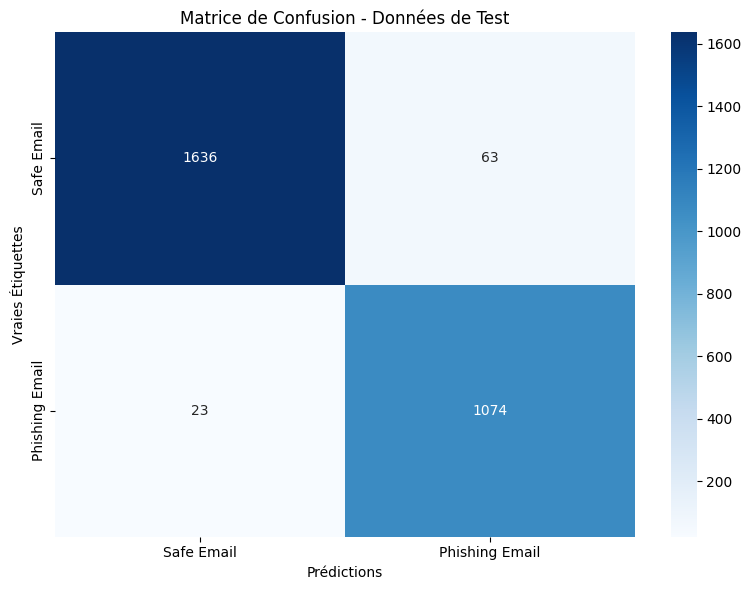

{'accuracy': 0.969241773962804,
 'predictions': array([1, 0, 1, ..., 0, 0, 0], shape=(2796,)),
 'true_labels': [1,
  0,
  1,
  1,
  1,
  0,
  1,
  0,
  0,
  0,
  1,
  1,
  1,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  1,
  0,
  1,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  1,
  1,
  0,
  1,
  1,
  0,
  1,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  1,
  0,
  1,
  1,
  0,
  0,
  0,
  1,
  1,
  1,
  0,
  0,
  1,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  1,
  0,
  1,
  0,
  1,
  0,
  1,
  0,
  0,
  0,
  1,
  1,
  1,
  0,
  1,
  0,
  0,
  1,
  0,
  1,
  0,
  1,
  1,
  0,
  0,
  1,
  0,
  1,
  0,
  1,


In [14]:
evaluate_on_test_data(model, tokenizer)

In [11]:
# =============================================================================
# 5. TESTS SUR NOUVEAUX EXEMPLES
# =============================================================================

def test_new_examples(model, tokenizer):
    """
    Teste le modèle sur de nouveaux exemples d'emails
    
    Args:
        model: Modèle entraîné
        tokenizer: Tokenizer
    """
    # Exemples d'emails pour tester
    test_emails = [
        {
            'subject': 'Email Netflix légitime',
            'content': """Dear Netflix Member,
We're updating our subscription prices to continue bringing you the best entertainment experience. 
Starting with your next billing period, the cost of your plan will change. Visit netflix.com/billing 
to review your options."""
        },
        {
            'subject': 'Email de phishing',
            'content': """URGENT: Your Account Has Been Limited!
We detected suspicious activity on your account. Click here to verify your identity now: 
http://secure-account-verify123.com. Failure to verify within 24 hours will result in permanent account closure."""
        }
        ,
        {
            'subject': 'Safe Email - Mise à jour de sécurité',
            'content': """yen outlook vince , as a followup to our meeting 
            with david port and rudi zipter re enron ' s investment in sk - enron , 
            maureen and i wrote the attached position paper on the japanese yen . 
            as we have discussed , the volatility of the won closely tracks fluctuation 
            in the yen , and this yen position paper is intended to complement the won outlook 
            piece for a broader perspective on currencies that takes into account the yen ' s 
            influence on asian currencies . . we would like to distribute this outlook
              to david and rudi , but wanted to send it to you for initial reaction prior 
              to internal distribution . thank you , and let me know if you have any 
              questions or comments re the attached . gwyn"""
        },

    ]
    
    # Tester chaque email
    for email in test_emails:
        print(f"\nTest de l'email : {email['subject']}")
        print("-" * 50)
        print(f"Contenu :\n{email['content']}\n")
        
        # Faire la prédiction
        prediction, class_id, probs = predict_single_email(email['content'], model, tokenizer)
        
        # Afficher les résultats
        print(f"Prédiction : {prediction}")
        print(f"Confiance : {probs[class_id]*100:.2f}%")
        print(f"Probabilités : Safe={probs[0]*100:.2f}%, Phishing={probs[1]*100:.2f}%")

In [12]:
test_new_examples(model, tokenizer)


Test de l'email : Email Netflix légitime
--------------------------------------------------
Contenu :
Dear Netflix Member,
We're updating our subscription prices to continue bringing you the best entertainment experience. 
Starting with your next billing period, the cost of your plan will change. Visit netflix.com/billing 
to review your options.

Prédiction : Phishing Email
Confiance : 98.48%
Probabilités : Safe=1.52%, Phishing=98.48%

Test de l'email : Email de phishing
--------------------------------------------------
Contenu :
URGENT: Your Account Has Been Limited!
We detected suspicious activity on your account. Click here to verify your identity now: 
http://secure-account-verify123.com. Failure to verify within 24 hours will result in permanent account closure.

Prédiction : Phishing Email
Confiance : 99.25%
Probabilités : Safe=0.75%, Phishing=99.25%

Test de l'email : Safe Email - Mise à jour de sécurité
--------------------------------------------------
Contenu :
yen outlook